In [41]:
import numpy as np
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt

import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())
from tslb.src.lzw import *
from tslb.src.utils import *
from tslb.src.regModel import regModel as regModel

plt.rcParams.update({'font.size': 14})

In [234]:
############### dropping some rows and pivoting ############

df = pd.read_pickle("../data/nba_scores_2103-2018.pkl")

##### create df_int : 5 sec interval scores
fr = '5S'

def get_year(df, yr=213):
    return df[(df.nbaId > yr*100000) & (df.nbaId < (yr+1)*100000)]

def get_matrix(df, fr='5S'):
    df_int = df.copy()
    df_int = df_int[df_int.TIME_INT.shift(-1) != df_int.TIME_INT]    # remove the rows with the same TIME_INT

    ### Create Matrix only with Q1-Q4
    # 1230 rows : 1230 games in total
    # 193 columns : 48 mins (4 Quarters) / 15 secs interval

    # only quarter 4
    df_q4 = df_int[df_int.TIME_INT <= pd.to_timedelta("00:48:00")]
    df_q4.loc[:,'TIME_INT'] = pd.to_datetime(df_q4.loc[:,'TIME_INT'])
    # time_index = pd.timedelta_range(start = pd.to_timedelta("00:00:00"), end = pd.to_timedelta("00:48:00"), freq='15s')

    df_q4_home = pd.pivot_table(df_q4, values='HOME_SCORE', columns=['nbaId'],index=['TIME_INT'])
    df_q4_home = df_q4_home.fillna(method = 'ffill')
    df_q4_home = df_q4_home.asfreq(freq=fr, method='ffill')

    df_q4_away = pd.pivot_table(df_q4, values='AWAY_SCORE', columns=['nbaId'],index=['TIME_INT'])
    df_q4_away = df_q4_away.fillna(method = 'ffill')
    df_q4_away = df_q4_away.asfreq(freq=fr, method='ffill')

    df_q4_home = df_q4_home.T
    df_q4_away = df_q4_away.T
    return df_q4_home, df_q4_away

# First Diff

In [242]:
def get_first_diff(seq):
    return (seq.shift(-1) - seq).values[:-1].astype(int)

In [283]:
# get data
fr = '15S'
yr = 214

#####
df_q4_home, df_q4_away = get_matrix(get_year(df, yr=yr), fr=fr)

#####
df_q4 = pd.concat([df_q4_home, df_q4_away])

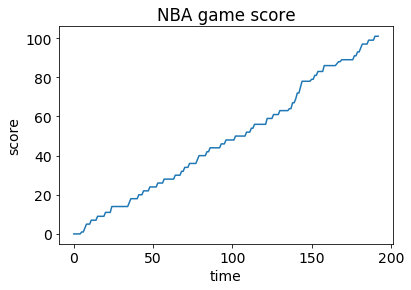

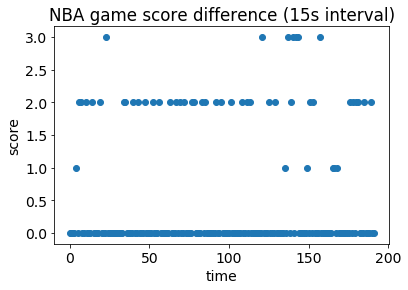

In [286]:
score = df_q4.iloc[0,:]
plt.title("NBA game score")
plt.plot(score.values)
plt.xlabel("time")
plt.ylabel("score")
plt.show()


plt.title("NBA game score difference (15s interval)")
plt.scatter(range(len(get_first_diff(score))),get_first_diff(score))
plt.xlabel("time")
plt.ylabel("score")
plt.show()

In [334]:
# get data
fr = '15S'
yr = 213

# lbs_df_all = pd.DataFrame()
for yr in [217,218]:

    #####
    df_q4_home, df_q4_away = get_matrix(get_year(df, yr=yr), fr=fr)

    samples = 100
    size = df_q4_home.shape[1]-1

    myRegModel3 = regModel(3, size, samples)
    myRegModel4 = regModel(4, size, samples)
    myRegModel5 = regModel(5, size, samples)
    myRegModel6 = regModel(6, size, samples)
    myRegModel7 = regModel(7, size, samples)

    myRegModel3.fit(plot=False)
    myRegModel4.fit(plot=False)
    myRegModel5.fit(plot=False)
    myRegModel6.fit(plot=False)
    myRegModel7.fit(plot=False)

    lbs_home=[]
    for i in range(df_q4_home.shape[0]):
        seq = df_q4_home.astype(int).iloc[i]
        uncomp_numbers = get_first_diff(seq)
        n = max(uncomp_numbers)+1

        print(n)    
        if n==3:
            myRegModel = myRegModel3
        elif n==4:
            myRegModel = myRegModel4
        elif n==5:
            myRegModel = myRegModel5
        elif n==6:
            myRegModel = myRegModel6
        elif n==7:
            myRegModel = myRegModel7
            
        if np.sum(uncomp_numbers <0) !=0:
            continue

        ratio = lzw_compression_ratio(uncomp_numbers, n)
        ent = myRegModel.get_entropy(ratio, "a multinomial sequence", False)
        lb = h_inverse(ent, n, a=0.001)
        lbs_home.append(lb)

    lbs_away=[]
    for i in range(df_q4_away.shape[0]):
        seq = df_q4_away.astype(int).iloc[i]
        uncomp_numbers = get_first_diff(seq)
        n = max(uncomp_numbers)+1

        print(n)    
        if n==3:
            myRegModel = myRegModel3
        elif n==4:
            myRegModel = myRegModel4
        elif n==5:
            myRegModel = myRegModel5
        elif n==6:
            myRegModel = myRegModel6
        elif n==7:
            myRegModel = myRegModel7
            
        if np.sum(uncomp_numbers <0) !=0:
            continue
            
        ratio = lzw_compression_ratio(uncomp_numbers, n)
        ent = myRegModel.get_entropy(ratio, "a multinomial sequence", False)
        lb = h_inverse(ent, n, a=0.001)
        lbs_away.append(lb)

    lbs = np.append(np.array(lbs_home), np.array(lbs_away))
    lbs_df = pd.DataFrame(lbs, columns=[yr])
    lbs_df_all = pd.concat([lbs_df_all, lbs_df], axis=1)

/Users/saeyoung/Documents/GitHub/tslb/venv/lib/python3.6/site-packages/pandas/util/_decorators.py:208: FutureWarning: Passing timedelta64-dtype data is deprecated, will raise a TypeError in a future version
  return func(*args, **kwargs)
/Users/saeyoung/Documents/GitHub/tslb/venv/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


4
compression ratio:  0.3125
16
4
compression ratio:  0.3020833333333333
5
compression ratio:  0.3385416666666667
4
compression ratio:  0.328125
5
compression ratio:  0.3333333333333333
6
4
compression ratio:  0.3072916666666667
5
compression ratio:  0.3125
5
compression ratio:  0.296875
4
compression ratio:  0.3020833333333333
4
compression ratio:  0.265625
5
compression ratio:  0.296875
4
compression ratio:  0.3229166666666667
6
compression ratio:  0.3229166666666667
4
compression ratio:  0.2916666666666667
11
4
compression ratio:  0.3177083333333333
4
compression ratio:  0.2916666666666667
6
compression ratio:  0.3385416666666667
4
compression ratio:  0.2864583333333333
5
compression ratio:  0.3177083333333333
5
compression ratio:  0.3125
4
compression ratio:  0.3020833333333333
21
7
compression ratio:  0.34375
5
compression ratio:  0.328125
4
compression ratio:  0.3072916666666667
18
compression ratio:  0.3125
4
compression ratio:  0.3229166666666667
4
compression ratio:  0.265625


4
compression ratio:  0.2916666666666667
4
compression ratio:  0.3072916666666667
4
compression ratio:  0.296875
4
compression ratio:  0.2916666666666667
4
compression ratio:  0.328125
5
compression ratio:  0.3125
4
compression ratio:  0.2916666666666667
4
compression ratio:  0.3125
4
compression ratio:  0.3177083333333333
4
compression ratio:  0.3229166666666667
4
compression ratio:  0.296875
4
compression ratio:  0.296875
4
compression ratio:  0.3072916666666667
4
compression ratio:  0.3125
6
compression ratio:  0.3020833333333333
4
compression ratio:  0.296875
4
compression ratio:  0.3125
4
compression ratio:  0.2864583333333333
5
compression ratio:  0.28125
4
compression ratio:  0.2864583333333333
5
compression ratio:  0.3125
4
compression ratio:  0.328125
4
compression ratio:  0.3229166666666667
4
compression ratio:  0.2916666666666667
4
compression ratio:  0.2864583333333333
4
compression ratio:  0.2864583333333333
4
compression ratio:  0.3020833333333333
4
compression ratio:  0.

4
compression ratio:  0.3072916666666667
5
compression ratio:  0.296875
7
compression ratio:  0.2916666666666667
4
compression ratio:  0.3020833333333333
5
compression ratio:  0.3177083333333333
5
compression ratio:  0.3020833333333333
4
compression ratio:  0.3020833333333333
4
compression ratio:  0.296875
6
compression ratio:  0.296875
5
compression ratio:  0.3020833333333333
4
compression ratio:  0.328125
4
compression ratio:  0.3125
4
compression ratio:  0.3125
4
compression ratio:  0.296875
5
compression ratio:  0.328125
4
compression ratio:  0.3072916666666667
4
compression ratio:  0.3385416666666667
4
compression ratio:  0.2916666666666667
5
compression ratio:  0.3229166666666667
4
compression ratio:  0.2864583333333333
7
compression ratio:  0.3125
4
compression ratio:  0.3177083333333333
4
compression ratio:  0.3177083333333333
4
compression ratio:  0.2864583333333333
4
compression ratio:  0.3125
7
compression ratio:  0.296875
4
compression ratio:  0.3229166666666667
5
compressi

5
compression ratio:  0.3072916666666667
4
compression ratio:  0.3177083333333333
4
compression ratio:  0.3020833333333333
4
compression ratio:  0.3072916666666667
4
compression ratio:  0.3125
4
compression ratio:  0.3177083333333333
4
compression ratio:  0.296875
5
compression ratio:  0.3229166666666667
5
compression ratio:  0.3385416666666667
4
compression ratio:  0.2760416666666667
6
compression ratio:  0.328125
4
compression ratio:  0.3333333333333333
4
compression ratio:  0.3177083333333333
4
compression ratio:  0.3177083333333333
4
compression ratio:  0.3177083333333333
4
compression ratio:  0.3020833333333333
4
compression ratio:  0.3072916666666667
4
compression ratio:  0.3125
4
compression ratio:  0.2916666666666667
4
compression ratio:  0.3125
4
compression ratio:  0.3020833333333333
4
compression ratio:  0.2916666666666667
5
compression ratio:  0.3072916666666667
4
compression ratio:  0.2916666666666667
4
compression ratio:  0.2916666666666667
4
compression ratio:  0.3125
4


4
compression ratio:  0.3020833333333333
4
compression ratio:  0.3333333333333333
4
compression ratio:  0.3177083333333333
4
compression ratio:  0.3072916666666667
4
compression ratio:  0.296875
4
compression ratio:  0.2864583333333333
4
compression ratio:  0.2916666666666667
7
compression ratio:  0.2916666666666667
4
compression ratio:  0.3125
4
compression ratio:  0.3072916666666667
5
compression ratio:  0.2864583333333333
4
compression ratio:  0.2760416666666667
5
compression ratio:  0.3229166666666667
5
compression ratio:  0.3333333333333333
6
compression ratio:  0.3072916666666667
4
compression ratio:  0.3072916666666667
4
compression ratio:  0.3177083333333333
6
compression ratio:  0.2864583333333333
5
compression ratio:  0.3229166666666667
4
compression ratio:  0.3020833333333333
5
compression ratio:  0.3385416666666667
4
compression ratio:  0.296875
6
compression ratio:  0.2916666666666667
4
compression ratio:  0.3229166666666667
4
compression ratio:  0.3229166666666667
4
compr

5
compression ratio:  0.2864583333333333
8
4
compression ratio:  0.3177083333333333
5
compression ratio:  0.3229166666666667
4
compression ratio:  0.328125
6
compression ratio:  0.3125
5
compression ratio:  0.3072916666666667
4
compression ratio:  0.328125
4
compression ratio:  0.296875
5
compression ratio:  0.3020833333333333
5
compression ratio:  0.3125
4
compression ratio:  0.328125
22
4
compression ratio:  0.3020833333333333
4
compression ratio:  0.2760416666666667
4
compression ratio:  0.296875
4
compression ratio:  0.328125
5
compression ratio:  0.328125
5
compression ratio:  0.3229166666666667
4
compression ratio:  0.3072916666666667
5
compression ratio:  0.3229166666666667
4
compression ratio:  0.3229166666666667
4
compression ratio:  0.3072916666666667
4
compression ratio:  0.3020833333333333
4
compression ratio:  0.3177083333333333
4
compression ratio:  0.2916666666666667
4
compression ratio:  0.2916666666666667
4
compression ratio:  0.296875
5
compression ratio:  0.322916666

6
compression ratio:  0.3125
4
compression ratio:  0.2916666666666667
5
compression ratio:  0.34375
4
compression ratio:  0.3125
4
compression ratio:  0.3072916666666667
4
compression ratio:  0.2760416666666667
5
compression ratio:  0.328125
4
compression ratio:  0.2916666666666667
4
compression ratio:  0.3125
4
compression ratio:  0.296875
4
compression ratio:  0.296875
4
compression ratio:  0.3125
4
compression ratio:  0.3020833333333333
6
compression ratio:  0.3020833333333333
4
compression ratio:  0.2916666666666667
4
compression ratio:  0.3229166666666667
4
compression ratio:  0.328125
4
compression ratio:  0.3020833333333333
4
compression ratio:  0.3177083333333333
5
compression ratio:  0.328125
4
compression ratio:  0.3020833333333333
5
compression ratio:  0.3125
5
compression ratio:  0.3125
5
compression ratio:  0.3020833333333333
4
compression ratio:  0.3020833333333333
4
compression ratio:  0.3125
4
compression ratio:  0.3125
4
compression ratio:  0.3072916666666667
4
compres

4
compression ratio:  0.28125
4
compression ratio:  0.3020833333333333
4
compression ratio:  0.3333333333333333
5
compression ratio:  0.3333333333333333
4
compression ratio:  0.296875
4
compression ratio:  0.2864583333333333
5
compression ratio:  0.3333333333333333
4
compression ratio:  0.2760416666666667
4
compression ratio:  0.3125
5
compression ratio:  0.3333333333333333
4
compression ratio:  0.2760416666666667
6
compression ratio:  0.3020833333333333
4
compression ratio:  0.2864583333333333
4
compression ratio:  0.3385416666666667
4
compression ratio:  0.296875
4
compression ratio:  0.296875
4
compression ratio:  0.3020833333333333
4
compression ratio:  0.2916666666666667
4
compression ratio:  0.296875
4
compression ratio:  0.3125
4
compression ratio:  0.3072916666666667
5
compression ratio:  0.3229166666666667
5
compression ratio:  0.296875
4
compression ratio:  0.3125
5
compression ratio:  0.328125
4
compression ratio:  0.2864583333333333
4
compression ratio:  0.2916666666666667


4
compression ratio:  0.3072916666666667
4
compression ratio:  0.3125
7
compression ratio:  0.328125
5
compression ratio:  0.3125
4
compression ratio:  0.2916666666666667
4
compression ratio:  0.3020833333333333
4
compression ratio:  0.3072916666666667
4
compression ratio:  0.2864583333333333
4
compression ratio:  0.28125
4
compression ratio:  0.296875
4
compression ratio:  0.3072916666666667
4
compression ratio:  0.3020833333333333
4
4
compression ratio:  0.296875
4
compression ratio:  0.2916666666666667
4
compression ratio:  0.3177083333333333
4
compression ratio:  0.3125
4
compression ratio:  0.296875
6
compression ratio:  0.28125
5
compression ratio:  0.3385416666666667
4
compression ratio:  0.3020833333333333
4
compression ratio:  0.296875
4
compression ratio:  0.3125
6
4
compression ratio:  0.3125
4
compression ratio:  0.2916666666666667
4
compression ratio:  0.3072916666666667
4
compression ratio:  0.2864583333333333
5
compression ratio:  0.328125
4
compression ratio:  0.3125
5


6
compression ratio:  0.3125
5
compression ratio:  0.3020833333333333
4
compression ratio:  0.3020833333333333
5
compression ratio:  0.3177083333333333
4
compression ratio:  0.3020833333333333
6
compression ratio:  0.3177083333333333
4
compression ratio:  0.28125
5
compression ratio:  0.3177083333333333
4
compression ratio:  0.3072916666666667
6
compression ratio:  0.328125
4
compression ratio:  0.3020833333333333
4
compression ratio:  0.296875
4
compression ratio:  0.3229166666666667
4
compression ratio:  0.296875
4
compression ratio:  0.3072916666666667
4
compression ratio:  0.2916666666666667
4
compression ratio:  0.296875
6
compression ratio:  0.3229166666666667
4
compression ratio:  0.3020833333333333
4
compression ratio:  0.296875
4
compression ratio:  0.328125
6
compression ratio:  0.3072916666666667
4
compression ratio:  0.2916666666666667
4
compression ratio:  0.328125
5
compression ratio:  0.3072916666666667
4
compression ratio:  0.28125
4
compression ratio:  0.28125
4
compre

/Users/saeyoung/Documents/GitHub/tslb/venv/lib/python3.6/site-packages/pandas/util/_decorators.py:208: FutureWarning: Passing timedelta64-dtype data is deprecated, will raise a TypeError in a future version
  return func(*args, **kwargs)
/Users/saeyoung/Documents/GitHub/tslb/venv/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


4
compression ratio:  0.3125
5
5
compression ratio:  0.3177083333333333
4
compression ratio:  0.3020833333333333
4
compression ratio:  0.3125
4
compression ratio:  0.3072916666666667
4
compression ratio:  0.3229166666666667
4
compression ratio:  0.3229166666666667
5
compression ratio:  0.328125
4
compression ratio:  0.3229166666666667
4
compression ratio:  0.3229166666666667
5
compression ratio:  0.3020833333333333
5
compression ratio:  0.3229166666666667
5
compression ratio:  0.34375
4
compression ratio:  0.328125
5
compression ratio:  0.3489583333333333
4
compression ratio:  0.2760416666666667
5
compression ratio:  0.3177083333333333
4
compression ratio:  0.3229166666666667
5
compression ratio:  0.3541666666666667
4
compression ratio:  0.3125
5
compression ratio:  0.3541666666666667
5
compression ratio:  0.3333333333333333
4
compression ratio:  0.3333333333333333
4
compression ratio:  0.328125
4
compression ratio:  0.3229166666666667
5
compression ratio:  0.3229166666666667
4
compres

4
compression ratio:  0.2916666666666667
4
compression ratio:  0.3125
6
compression ratio:  0.3072916666666667
5
compression ratio:  0.3072916666666667
4
compression ratio:  0.3020833333333333
4
compression ratio:  0.3072916666666667
5
compression ratio:  0.3333333333333333
5
compression ratio:  0.328125
4
compression ratio:  0.296875
5
compression ratio:  0.3072916666666667
4
compression ratio:  0.3020833333333333
4
compression ratio:  0.3125
5
compression ratio:  0.328125
4
compression ratio:  0.296875
4
compression ratio:  0.3229166666666667
5
compression ratio:  0.3333333333333333
4
compression ratio:  0.3333333333333333
4
compression ratio:  0.3229166666666667
4
compression ratio:  0.3020833333333333
4
compression ratio:  0.3229166666666667
6
compression ratio:  0.3177083333333333
4
compression ratio:  0.3072916666666667
6
compression ratio:  0.3229166666666667
4
compression ratio:  0.3177083333333333
4
compression ratio:  0.3333333333333333
4
compression ratio:  0.302083333333333

4
compression ratio:  0.3072916666666667
5
compression ratio:  0.3177083333333333
4
compression ratio:  0.3125
5
compression ratio:  0.328125
4
compression ratio:  0.3177083333333333
4
compression ratio:  0.3333333333333333
4
compression ratio:  0.3072916666666667
4
compression ratio:  0.3333333333333333
4
compression ratio:  0.3229166666666667
4
compression ratio:  0.3072916666666667
4
compression ratio:  0.3489583333333333
4
compression ratio:  0.3072916666666667
4
compression ratio:  0.3020833333333333
4
compression ratio:  0.328125
4
compression ratio:  0.3072916666666667
4
compression ratio:  0.328125
4
compression ratio:  0.3177083333333333
5
compression ratio:  0.3541666666666667
5
compression ratio:  0.3072916666666667
4
compression ratio:  0.3125
5
compression ratio:  0.3229166666666667
4
compression ratio:  0.3020833333333333
4
compression ratio:  0.3020833333333333
5
compression ratio:  0.3229166666666667
4
compression ratio:  0.3072916666666667
4
compression ratio:  0.32812

5
compression ratio:  0.3072916666666667
4
compression ratio:  0.3177083333333333
4
compression ratio:  0.3385416666666667
5
compression ratio:  0.328125
4
compression ratio:  0.3125
4
compression ratio:  0.3125
4
compression ratio:  0.328125
4
compression ratio:  0.3177083333333333
4
compression ratio:  0.328125
4
compression ratio:  0.3177083333333333
5
compression ratio:  0.328125
5
compression ratio:  0.328125
4
compression ratio:  0.3333333333333333
4
compression ratio:  0.3072916666666667
4
compression ratio:  0.3177083333333333
5
compression ratio:  0.328125
4
compression ratio:  0.3125
6
compression ratio:  0.3020833333333333
4
compression ratio:  0.3229166666666667
4
compression ratio:  0.296875
5
compression ratio:  0.34375
4
compression ratio:  0.34375
4
compression ratio:  0.3072916666666667
4
compression ratio:  0.3125
5
compression ratio:  0.3229166666666667
4
compression ratio:  0.2916666666666667
5
compression ratio:  0.3333333333333333
4
compression ratio:  0.302083333

4
compression ratio:  0.3177083333333333
4
compression ratio:  0.2916666666666667
5
compression ratio:  0.328125
4
compression ratio:  0.3229166666666667
4
compression ratio:  0.328125
5
compression ratio:  0.3177083333333333
4
compression ratio:  0.296875
4
compression ratio:  0.3229166666666667
4
compression ratio:  0.3333333333333333
4
compression ratio:  0.296875
4
compression ratio:  0.3177083333333333
5
compression ratio:  0.3333333333333333
4
compression ratio:  0.3072916666666667
5
compression ratio:  0.3229166666666667
6
compression ratio:  0.3125
4
compression ratio:  0.328125
5
compression ratio:  0.3229166666666667
6
compression ratio:  0.3125
5
compression ratio:  0.3072916666666667
4
compression ratio:  0.3333333333333333
4
compression ratio:  0.3229166666666667
4
compression ratio:  0.296875
4
compression ratio:  0.3020833333333333
4
compression ratio:  0.3020833333333333
4
compression ratio:  0.3020833333333333
4
compression ratio:  0.28125
4
compression ratio:  0.28125

5
compression ratio:  0.34375
4
compression ratio:  0.3229166666666667
6
compression ratio:  0.3385416666666667
5
compression ratio:  0.3177083333333333
5
compression ratio:  0.3177083333333333
4
compression ratio:  0.3072916666666667
4
compression ratio:  0.3385416666666667
4
compression ratio:  0.2864583333333333
4
compression ratio:  0.3333333333333333
4
compression ratio:  0.3072916666666667
4
compression ratio:  0.2864583333333333
4
compression ratio:  0.3072916666666667
4
compression ratio:  0.3177083333333333
4
compression ratio:  0.3072916666666667
4
compression ratio:  0.3125
4
compression ratio:  0.3020833333333333
5
compression ratio:  0.3125
5
compression ratio:  0.3072916666666667
5
compression ratio:  0.3229166666666667
4
compression ratio:  0.2916666666666667
5
compression ratio:  0.3072916666666667
4
compression ratio:  0.3125
5
compression ratio:  0.328125
4
compression ratio:  0.3177083333333333
4
compression ratio:  0.3072916666666667
4
compression ratio:  0.3125
4
c

4
compression ratio:  0.3020833333333333
4
compression ratio:  0.3177083333333333
4
compression ratio:  0.265625
4
compression ratio:  0.2916666666666667
4
compression ratio:  0.3125
4
compression ratio:  0.3177083333333333
4
compression ratio:  0.296875
4
compression ratio:  0.3072916666666667
4
compression ratio:  0.2760416666666667
5
compression ratio:  0.3333333333333333
5
5
compression ratio:  0.2916666666666667
4
compression ratio:  0.3177083333333333
4
compression ratio:  0.3229166666666667
4
compression ratio:  0.3020833333333333
5
compression ratio:  0.2760416666666667
4
compression ratio:  0.3333333333333333
6
compression ratio:  0.3072916666666667
4
compression ratio:  0.3020833333333333
4
compression ratio:  0.3125
4
compression ratio:  0.3020833333333333
4
compression ratio:  0.328125
4
compression ratio:  0.296875
4
compression ratio:  0.3020833333333333
4
compression ratio:  0.3020833333333333
5
compression ratio:  0.3385416666666667
4
compression ratio:  0.328125
4
comp

4
compression ratio:  0.296875
4
compression ratio:  0.3020833333333333
6
compression ratio:  0.3333333333333333
4
compression ratio:  0.2916666666666667
4
compression ratio:  0.328125
4
compression ratio:  0.3072916666666667
4
compression ratio:  0.3072916666666667
5
compression ratio:  0.3229166666666667
5
compression ratio:  0.3177083333333333
4
compression ratio:  0.328125
4
compression ratio:  0.3020833333333333
5
compression ratio:  0.3072916666666667
4
compression ratio:  0.3229166666666667
5
compression ratio:  0.3072916666666667
4
compression ratio:  0.3177083333333333
4
compression ratio:  0.3020833333333333
4
compression ratio:  0.3020833333333333
4
compression ratio:  0.3229166666666667
4
compression ratio:  0.3072916666666667
4
compression ratio:  0.2916666666666667
4
compression ratio:  0.2916666666666667
5
compression ratio:  0.3125
4
compression ratio:  0.3229166666666667
4
compression ratio:  0.328125
4
compression ratio:  0.3020833333333333
4
compression ratio:  0.317

5
compression ratio:  0.3125
4
compression ratio:  0.3072916666666667
5
compression ratio:  0.3072916666666667
4
compression ratio:  0.296875
4
compression ratio:  0.328125
5
compression ratio:  0.3229166666666667
4
compression ratio:  0.3229166666666667
4
compression ratio:  0.3333333333333333
4
compression ratio:  0.3177083333333333
4
compression ratio:  0.265625
4
compression ratio:  0.3177083333333333
5
compression ratio:  0.3177083333333333
4
compression ratio:  0.3229166666666667
4
compression ratio:  0.3177083333333333
5
compression ratio:  0.3229166666666667
4
compression ratio:  0.3072916666666667
4
compression ratio:  0.3125
4
compression ratio:  0.328125
4
compression ratio:  0.34375
6
compression ratio:  0.34375
4
compression ratio:  0.328125
4
compression ratio:  0.3020833333333333
6
compression ratio:  0.328125
5
compression ratio:  0.3072916666666667
4
compression ratio:  0.3072916666666667
4
compression ratio:  0.3177083333333333
4
compression ratio:  0.296875
4
compres

4
compression ratio:  0.3020833333333333
4
compression ratio:  0.34375
4
compression ratio:  0.3072916666666667
4
compression ratio:  0.3020833333333333
4
compression ratio:  0.3020833333333333
5
compression ratio:  0.3177083333333333
4
compression ratio:  0.2760416666666667
5
compression ratio:  0.3229166666666667
4
compression ratio:  0.296875
5
compression ratio:  0.3125
5
compression ratio:  0.3385416666666667
4
compression ratio:  0.328125
4
compression ratio:  0.328125
4
compression ratio:  0.328125
4
compression ratio:  0.3333333333333333
4
compression ratio:  0.3125
5
compression ratio:  0.3177083333333333
4
compression ratio:  0.2916666666666667
4
compression ratio:  0.3177083333333333
6
compression ratio:  0.296875
4
compression ratio:  0.3020833333333333
5
compression ratio:  0.34375
4
compression ratio:  0.296875
4
compression ratio:  0.3072916666666667
4
compression ratio:  0.34375
5
compression ratio:  0.3177083333333333
4
compression ratio:  0.3020833333333333
5
compress

In [339]:
lbs_df_all

,2013,2014,2015,2016,217,218
0,0.227698,0.242917,0.197065,0.272559,0.232945,0.245304
1,0.244422,0.208821,0.230205,0.213943,0.215826,0.245106
2,0.244422,0.200725,0.213281,0.221822,0.252587,0.228628
3,0.202876,0.216827,0.221655,0.246409,0.260028,0.245304
4,0.262658,0.203468,0.205492,0.263671,0.244497,0.236882
...,...,...,...,...,...,...
2455,0.210187,0.251898,0.221655,0.191220,NaN,NaN
2456,0.205645,0.196942,0.221655,0.173906,NaN,NaN
2457,0.227698,0.192790,0.213281,0.198661,NaN,NaN
2458,0.218482,0.243645,0.205106,0.213943,NaN,NaN


In [338]:
lbs_df

,218
0,0.245304
1,0.245106
2,0.228628
3,0.245304
4,0.236882
...,...
2434,0.245304
2435,0.197216
2436,0.204850
2437,0.274491


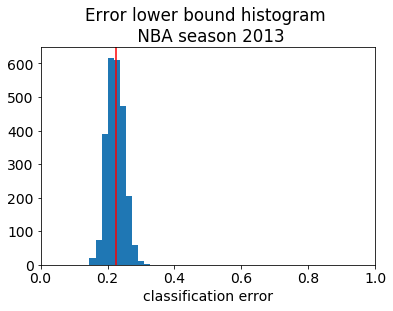

mean   :  0.22379110126897706
median :  0.2232267489189725
min    :  0.14594272295594643
max    :  0.32770663650322285


In [302]:
plt.title("Error lower bound histogram \n NBA season 2013")
plt.hist(lbs)
plt.axvline(np.mean(lbs), color='red')
plt.xlim(0,1)
plt.xlabel("classification error")
plt.show()
print("mean   : ", np.mean(lbs))
print("median : ", np.median(lbs))
print("min    : ", np.min(lbs))
print("max    : ", np.max(lbs))

In [265]:
# get data
fr = '15S'
yr = 218

#####
df_q4_home, df_q4_away = get_matrix(get_year(df, yr=yr), fr=fr)

samples = 100
size = df_q4_home.shape[1]-1

myRegModel3 = regModel(3, size, samples)
myRegModel4 = regModel(4, size, samples)
myRegModel5 = regModel(5, size, samples)
myRegModel6 = regModel(6, size, samples)
myRegModel7 = regModel(7, size, samples)

myRegModel3.fit(plot=False)
myRegModel4.fit(plot=False)
myRegModel5.fit(plot=False)
myRegModel6.fit(plot=False)
myRegModel7.fit(plot=False)

lbs=[]
for i in range(df_q4_home.shape[0]):
    seq = df_q4_home.astype(int).iloc[i]
    uncomp_numbers = get_first_diff(seq)
    n = max(uncomp_numbers)+1
    
    if (np.sum(uncomp_numbers<0) != 0):
        continue
    
    print(n)    
    if n==3:
        myRegModel = myRegModel3
    elif n==4:
        myRegModel = myRegModel4
    elif n==5:
        myRegModel = myRegModel5
    elif n==6:
        myRegModel = myRegModel6
    elif n==7:
        myRegModel = myRegModel7

    ratio = lzw_compression_ratio(uncomp_numbers, n)
    ent = myRegModel.get_entropy(ratio, "a multinomial sequence", False)
    lb = h_inverse(ent, n, a=0.001)
    lbs.append(lb)

/Users/saeyoung/Documents/GitHub/tslb/venv/lib/python3.6/site-packages/pandas/util/_decorators.py:208: FutureWarning: Passing timedelta64-dtype data is deprecated, will raise a TypeError in a future version
  return func(*args, **kwargs)
/Users/saeyoung/Documents/GitHub/tslb/venv/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


4
compression ratio:  0.3125
5
compression ratio:  0.3177083333333333
4
compression ratio:  0.3020833333333333
4
compression ratio:  0.3125
4
compression ratio:  0.3072916666666667
4
compression ratio:  0.3229166666666667
4
compression ratio:  0.3229166666666667
5
compression ratio:  0.328125
4
compression ratio:  0.3229166666666667
4
compression ratio:  0.3229166666666667
5
compression ratio:  0.3020833333333333
5
compression ratio:  0.3229166666666667
5
compression ratio:  0.34375
4
compression ratio:  0.328125
5
compression ratio:  0.3489583333333333
4
compression ratio:  0.2760416666666667
5
compression ratio:  0.3177083333333333
4
compression ratio:  0.3229166666666667
5
compression ratio:  0.3541666666666667
4
compression ratio:  0.3125
5
compression ratio:  0.3541666666666667
5
compression ratio:  0.3333333333333333
4
compression ratio:  0.3333333333333333
4
compression ratio:  0.328125
4
compression ratio:  0.3229166666666667
5
compression ratio:  0.3229166666666667
4
compressi

4
compression ratio:  0.296875
5
compression ratio:  0.3177083333333333
4
compression ratio:  0.3177083333333333
4
compression ratio:  0.28125
4
compression ratio:  0.28125
4
compression ratio:  0.3333333333333333
5
compression ratio:  0.3385416666666667
4
compression ratio:  0.3072916666666667
4
compression ratio:  0.2864583333333333
4
compression ratio:  0.3072916666666667
4
compression ratio:  0.3177083333333333
4
compression ratio:  0.3072916666666667
4
compression ratio:  0.3020833333333333
4
compression ratio:  0.3177083333333333
5
compression ratio:  0.3020833333333333
4
compression ratio:  0.3333333333333333
5
compression ratio:  0.328125
5
compression ratio:  0.3229166666666667
5
compression ratio:  0.2916666666666667
5
compression ratio:  0.328125
4
compression ratio:  0.3229166666666667
5
compression ratio:  0.3333333333333333
4
compression ratio:  0.3020833333333333
4
compression ratio:  0.34375
4
compression ratio:  0.2916666666666667
5
compression ratio:  0.30208333333333

4
compression ratio:  0.28125
4
compression ratio:  0.328125
5
compression ratio:  0.3177083333333333
5
compression ratio:  0.3333333333333333
4
compression ratio:  0.3020833333333333
4
compression ratio:  0.3020833333333333
5
compression ratio:  0.3333333333333333
4
compression ratio:  0.296875
4
compression ratio:  0.3125
4
compression ratio:  0.2916666666666667
4
compression ratio:  0.328125
5
compression ratio:  0.3385416666666667
4
compression ratio:  0.3125
4
compression ratio:  0.3125
4
compression ratio:  0.2864583333333333
4
compression ratio:  0.3385416666666667
4
compression ratio:  0.3072916666666667
5
compression ratio:  0.3177083333333333
4
compression ratio:  0.3177083333333333
6
compression ratio:  0.3229166666666667
4
compression ratio:  0.3072916666666667
4
compression ratio:  0.3072916666666667
4
compression ratio:  0.3072916666666667
4
compression ratio:  0.296875
4
compression ratio:  0.3177083333333333
4
compression ratio:  0.296875
5
compression ratio:  0.3072916

4
compression ratio:  0.3125
4
compression ratio:  0.328125
4
compression ratio:  0.3072916666666667
4
compression ratio:  0.3072916666666667
4
compression ratio:  0.3072916666666667
5
compression ratio:  0.296875
5
compression ratio:  0.3125
5
compression ratio:  0.328125
4
compression ratio:  0.3072916666666667
5
compression ratio:  0.3229166666666667
5
compression ratio:  0.3333333333333333
4
compression ratio:  0.3229166666666667
4
compression ratio:  0.328125
4
compression ratio:  0.296875
4
compression ratio:  0.3072916666666667
4
compression ratio:  0.2864583333333333
4
compression ratio:  0.2864583333333333
4
compression ratio:  0.3072916666666667
4
compression ratio:  0.296875
4
compression ratio:  0.2864583333333333
5
compression ratio:  0.3177083333333333
6
compression ratio:  0.3385416666666667
4
compression ratio:  0.2864583333333333
5
compression ratio:  0.3020833333333333
4
compression ratio:  0.28125
4
compression ratio:  0.328125
5
compression ratio:  0.3125
6
compress

4
compression ratio:  0.3333333333333333
4
compression ratio:  0.3072916666666667
4
compression ratio:  0.296875
5
compression ratio:  0.3072916666666667
4
compression ratio:  0.296875
5
compression ratio:  0.328125
4
compression ratio:  0.3177083333333333
8
compression ratio:  0.3229166666666667
4
compression ratio:  0.2916666666666667
4
compression ratio:  0.3020833333333333
5
compression ratio:  0.3177083333333333
4
compression ratio:  0.3229166666666667
6
compression ratio:  0.3229166666666667
4
compression ratio:  0.3177083333333333
5
compression ratio:  0.3229166666666667
4
compression ratio:  0.2916666666666667
4
compression ratio:  0.3229166666666667
4
compression ratio:  0.328125
4
compression ratio:  0.3020833333333333
5
compression ratio:  0.3177083333333333
4
compression ratio:  0.3229166666666667
4
compression ratio:  0.2916666666666667
5
compression ratio:  0.3072916666666667
4
compression ratio:  0.3229166666666667
4
compression ratio:  0.3177083333333333
4
compression r

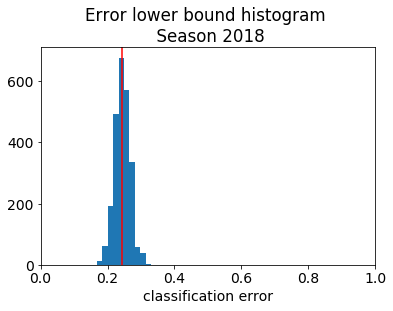

mean   :  0.24433102365106862
median :  0.24530361492669286
min    :  0.16808514569253766
max    :  0.33


In [343]:
plt.title("Error lower bound histogram \n Season 2018")
plt.hist(lbs)
plt.axvline(np.mean(lbs), color='red')
plt.xlim(0,1)
plt.xlabel("classification error")
plt.show()
print("mean   : ", np.mean(lbs))
print("median : ", np.median(lbs))
print("min    : ", np.min(lbs))
print("max    : ", np.max(lbs))

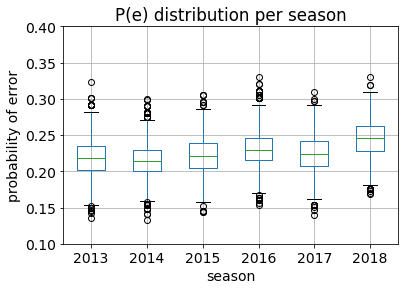

In [342]:
lbs_df_all.columns=["2013","2014","2015","2016", "2017", "2018"]
plt.title("P(e) distribution per season")
lbs_df_all.boxplot()
plt.xlabel("season")
plt.ylabel("probability of error")
# plt.ylim(0.1,0.4)
plt.show()

,213,214,215,216
0,0.227698,0.242917,0.197065,0.272559
1,0.244422,0.208821,0.230205,0.213943
2,0.244422,0.200725,0.213281,0.221822
3,0.202876,0.216827,0.221655,0.246409
4,0.262658,0.203468,0.205492,0.263671
...,...,...,...,...
2455,0.210187,0.251898,0.221655,0.191220
2456,0.205645,0.196942,0.221655,0.173906
2457,0.227698,0.192790,0.213281,0.198661
2458,0.218482,0.243645,0.205106,0.213943
